# Phase 1: Setup and Environment (Colab)

In [ ]:
# Core LangChain library
!pip install langchain -q

# PDF Loaders & Dependencies (Unstructured is powerful for complex PDFs)
# We install 'local-inference' which bundles models for layout detection
!pip install "unstructured[local-inference]" -q
# Install specific libraries needed by Unstructured and for image processing
!pip install pypdf pdf2image pytesseract Pillow poppler-utils -q

# Alternative/Simpler PDF loader often used with LangChain
# pip install pypdf -q # Already installed above

# OCR Tool (EasyOCR recommended for simplicity)
!pip install easyocr -q

# Vector Store
!pip install chromadb -q

# Dependencies required by some PDF/Image processing tools on Linux (Colab runs Linux)
# Install poppler-utils for pdf2image, Tesseract for OCR (even if using EasyOCR, some tools might need it)
!sudo apt-get update
!sudo apt-get install poppler-utils tesseract-ocr -y!

In [ ]:
!pip install --upgrade langchain-community -q
!apt-get install -y libmagic-dev poppler-utils tesseract-ocr


In [ ]:
!pip install "unstructured[local-inference,pdf,ocr]" -q

In [ ]:
!pip install --upgrade "numpy<2.0.0" --force-reinstall
!pip install --upgrade easyocr --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 103.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
  Using cached easyocr-1.7.2-py3-none-any.whl.metadata (10 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.4 MB/s eta 0:00:00
  Using cached python_bidi-0.6.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached pyclipper-1.3.0.post6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.w

In [ ]:
!pip install --upgrade pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 67.6 MB/s eta 0:00:00


# Phase 2: Data Extraction and Preprocessing

In [ ]:
import os
from langchain_community.document_loaders import UnstructuredPDFLoader
from pdf2image import convert_from_path
import easyocr
from PIL import Image # Pillow is needed for image operations
import warnings

# Suppress specific warnings if they become noisy
warnings.filterwarnings("ignore", category=UserWarning, module='unstructured')
warnings.filterwarnings("ignore", category=FutureWarning) # Often from underlying libraries like transformers

In [ ]:
pdf_files = [
    "/content/2. financials.pdf",
    "/content/1. Annual Report 2023-24.pdf",
    "/content/3. FYP-Handbook-2023.pdf"
]

# Directory to store extracted images (optional, but good practice)
output_image_dir = "extractedpdfimages"
os.makedirs(output_image_dir, exist_ok=True)

# List to hold all extracted data chunks
all_extracted_data = []

# Initialize EasyOCR Reader (do this once)
# Specify 'en' for English. It will download the model the first time.
print("Initializing EasyOCR Reader...")
reader = easyocr.Reader(['en'])
print("EasyOCR Reader Initialized.")

Initializing EasyOCR Reader...
EasyOCR Reader Initialized.


In [ ]:
import fitz


In [ ]:
from unstructured.partition.pdf import partition_pdf  # Correct import
import cv2
def process_pdf(pdf_path):
    base_filename = os.path.splitext(os.path.basename(pdf_path))[0]
    pdf_image_subdir = os.path.join(output_image_dir, base_filename)
    os.makedirs(pdf_image_subdir, exist_ok=True)

    # === Part 1: Structured Extraction ===
    print(f"\nExtracting structured elements from {pdf_path}...")
    try:
        # Correct usage of partition_pdf
        elements = partition_pdf(
            filename=pdf_path,
            strategy="hi_res",
            infer_table_structure=True,
            include_page_breaks=True
        )

        for element in elements:
            all_extracted_data.append({
                "content": str(element),
                "metadata": {
                    "source": pdf_path,
                    "type": element.category.lower(),
                    "page": element.metadata.page_number,
                    "element_id": f"{pdf_path}_p{element.metadata.page_number}_{element.id}"  # NEW

                }
            })
        print(f"Extracted {len(elements)} structured elements")
    except Exception as e:
        print(f"Unstructured processing error: {str(e)}")

    # === Part 2: Image/OCR Processing ===
    print("Extracting images with OCR...")
    print("  Extracting images and performing OCR with PyMuPDF/EasyOCR...")
    processed_image_refs = set() # Keep track of images processed by Unstructured if extract_images_in_pdf=True
    try:
        doc = fitz.open(pdf_path)
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            page_id_str = f"{os.path.basename(pdf_path)}_p{page_num+1}"

            # Text extraction fallback
            text = page.get_text("text") # Get plain text
            if text.strip():
                all_extracted_data.append({
                    "content": text,
                    "metadata": { "source": pdf_path, "type": "direct_text", "page": page_num + 1, "element_id": f"{page_id_str}_directtext" }
                })

            # Image processing
            img_list = page.get_images(full=True)
            for img_index, img in enumerate(img_list, 1):
                xref = img[0]
                if xref in processed_image_refs: # Skip if already handled by Unstructured (optional)
                    continue

                try:
                    base_image = doc.extract_image(xref)
                    img_bytes = base_image["image"]
                    img_ext = base_image["ext"]
                    img_path = f"{pdf_image_subdir}/page_{page_num+1}_img_{img_index}.{img_ext}"

                    # Save the image
                    with open(img_path, "wb") as f:
                        f.write(img_bytes)

                    # --- Prepare for OCR ---
                    # Check image size, skip if too small (likely noise)
                    pil_temp_img = Image.open(img_path)
                    if pil_temp_img.width < 50 or pil_temp_img.height < 50:
                        # print(f"    Skipping small image: {img_path}") # Optional debug
                        pil_temp_img.close()
                        os.remove(img_path) # Clean up small image file
                        continue
                    pil_temp_img.close()


                    # Use OpenCV to decode for EasyOCR
                    img_np = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_COLOR)
                    if img_np is None: # Check if decoding failed
                         print(f"    Warning: Could not decode image {img_path}. Skipping OCR.")
                         continue

                    # OCR processing
                    ocr_results = reader.readtext(img_np)
                    ocr_text = " ".join([res[1] for res in ocr_results if len(res[1]) > 1]) # Join detected text, filter very short results

                    # Add OCR results ONLY if substantial text is found
                    if len(ocr_text) > 10: # Threshold for meaningful OCR text
                        all_extracted_data.append({
                            "content": ocr_text,
                            "metadata": {
                                "source": pdf_path,
                                "type": "ocr_text", # Specific type for OCR
                                "page": page_num + 1,
                                "image_path": img_path, # Store path for reference
                                "element_id": f"{page_id_str}_img_{img_index}_ocr"
                            }
                        })
                    # Keep the image path even if OCR text is minimal, for image embedding later
                    all_extracted_data.append({
                        "content": f"Image from {os.path.basename(pdf_path)}, page {page_num+1}, index {img_index}", # Placeholder content
                        "metadata": {
                            "source": pdf_path,
                            "type": "image", # Specific type for the image itself
                            "page": page_num + 1,
                            "image_path": img_path,
                            "element_id": f"{page_id_str}_img_{img_index}_visual"
                        }
                    })


                except Exception as img_e:
                    print(f"    Error processing image {img_index} on page {page_num+1}: {str(img_e)}")
        doc.close()
    except Exception as e:
        print(f"  Error during PyMuPDF/EasyOCR processing: {str(e)}")



In [ ]:
# Process all PDF files
for pdf_file in pdf_files:
    if os.path.exists(pdf_file):
        print(f"\n=== Processing {pdf_file} ===")
        process_pdf(pdf_file)
    else:
        print(f"\nFile not found: {pdf_file}")

print("\n=== Processing Complete ===")
print(f"Total extracted elements: {len(all_extracted_data)}")


=== Processing /content/2. financials.pdf ===

Extracting structured elements from /content/2. financials.pdf...


Extracted 494 structured elements
Extracting images with OCR...
  Extracting images and performing OCR with PyMuPDF/EasyOCR...

=== Processing /content/1. Annual Report 2023-24.pdf ===

Extracting structured elements from /content/1. Annual Report 2023-24.pdf...


Extracted 1077 structured elements
Extracting images with OCR...
  Extracting images and performing OCR with PyMuPDF/EasyOCR...

=== Processing /content/3. FYP-Handbook-2023.pdf ===

Extracting structured elements from /content/3. FYP-Handbook-2023.pdf...
Extracted 682 structured elements
Extracting images with OCR...
  Extracting images and performing OCR with PyMuPDF/EasyOCR...

=== Processing Complete ===
Total extracted elements: 2735


In [ ]:
# Print summary of extracted data
print("\n=== Extraction Summary ===")
for doc in pdf_files:
    doc_elements = [e for e in all_extracted_data if e['metadata']['source'] == doc]
    print(f"\nDocument: {doc}")
    print(f"Total elements extracted: {len(doc_elements)}")

    # Count by type
    type_counts = {}
    for elem in doc_elements:
        elem_type = elem['metadata']['type']
        type_counts[elem_type] = type_counts.get(elem_type, 0) + 1

    print("Element types:")
    for typ, count in type_counts.items():
        print(f"  {typ}: {count}")

# Sample output
print("\n=== Sample Elements ===")
for i, elem in enumerate(all_extracted_data[:5]):
    print(f"\nElement {i+1}:")
    print(f"Type: {elem['metadata']['type']}")
    print(f"Page: {elem['metadata'].get('page', 'N/A')}")
    print(f"Content snippet: {elem['content'][:200]}...")


=== Extraction Summary ===

Document: /content/2. financials.pdf
Total elements extracted: 574
Element types:
  image: 111
  title: 132
  narrativetext: 103
  pagebreak: 35
  table: 9
  footer: 39
  listitem: 59
  uncategorizedtext: 14
  figurecaption: 18
  header: 6
  direct_text: 35
  ocr_text: 13

Document: /content/1. Annual Report 2023-24.pdf
Total elements extracted: 1175
Element types:
  title: 338
  image: 35
  narrativetext: 396
  pagebreak: 85
  uncategorizedtext: 59
  table: 36
  listitem: 135
  figurecaption: 4
  footer: 2
  direct_text: 85

Document: /content/3. FYP-Handbook-2023.pdf
Total elements extracted: 986
Element types:
  image: 375
  narrativetext: 137
  title: 115
  pagebreak: 62
  uncategorizedtext: 79
  table: 24
  listitem: 129
  figurecaption: 3
  direct_text: 61
  ocr_text: 1

=== Sample Elements ===

Element 1:
Type: image
Page: 1
Content snippet: ...

Element 2:
Type: image
Page: 1
Content snippet: ...

Element 3:
Type: title
Page: 1
Content snippet: Basi

Unstructured: It will try its best to identify logical blocks (paragraphs, titles, lists, potentially tables). Tables might appear as HTML strings or just text within the content. Check the output carefully. The metadata might contain a category key (like 'Table', 'Title', 'NarrativeText').
pdf2image & EasyOCR: This part ensures all visual text is captured. convert_from_path creates PIL Image objects for each page. We save these to disk (in the extracted_pdf_images folder, organized by PDF) and then feed the path to EasyOCR. reader.readtext returns a list of detections; we join the text parts.
all_extracted_data: This list now holds dictionaries. Each dictionary represents a potential "chunk" for your RAG system.
Some chunks are text/table elements identified by unstructured.
Other chunks represent entire pages processed by OCR, containing the text extracted from the image of that page. This ensures text within charts, graphs, and diagrams is captured.
Metadata: Each chunk has source (PDF filename), page number, and a type ('text', 'table', 'image_ocr', etc.). The image chunks also have image_path.
Potential Redundancy: Note that text appearing on a page might now exist in two chunks: once in a text element from unstructured, and again within the image_ocr chunk for that page. This isn't necessarily bad for RAG, as it increases the chances of retrieving relevant context, but it's something to be aware of. We might refine this later if needed.

# Phase 3 : Chunk and Emb

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from PIL import Image
import torch # Sentence Transformers uses PyTorch

# == Step 2.1: Define Text Splitter ==
# Choose chunk size and overlap appropriate for CLIP and context needs.
# CLIP models often work well with shorter sequences. Let's try 512 chars.
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,  # Reduced for model safety
    chunk_overlap=30,
    length_function=len,
    separators=["\n\n", "\n", ". ", " ", ""]  # Explicit separators
)


final_chunks_for_embedding = []
image_paths_processed = set() # To avoid duplicating image entries if OCR failed but image was added

TEXT_CATEGORIES = {"Table", "NarrativeText", "Title", "ListItem", "ocr_text", "direct_text", "Header", "Footer"} # Categories to chunk

for item in all_extracted_data:
    metadata = item['metadata']
    content = item['content']
    item_type = metadata.get('type')

    if item_type == 'image':
        image_path = metadata.get('image_path')
        if image_path and image_path not in image_paths_processed:
            # Keep image items directly, no chunking needed for the image itself
            final_chunks_for_embedding.append(item)
            image_paths_processed.add(image_path)
    elif item_type in TEXT_CATEGORIES:
        # Chunk the text content
        text_chunks = text_splitter.split_text(content)
        for i, chunk_text in enumerate(text_chunks):
            chunk_metadata = metadata.copy()
            chunk_metadata['chunk_index'] = i # Add chunk index to metadata
            chunk_metadata['element_id'] = f"{metadata['element_id']}_chunk_{i}" # Unique ID for the chunk
            final_chunks_for_embedding.append({
                'content': chunk_text,
                'metadata': chunk_metadata
            })
    # else: # Handle other types if necessary, e.g., keep them as is or discard
    #     print(f"Skipping chunking for type: {item_type}")


print(f"Created {len(final_chunks_for_embedding)} final chunks for embedding (including images).")


Created 1805 final chunks for embedding (including images).


In [ ]:

from transformers import CLIPProcessor, CLIPModel
import torch
# == Step 3: Initialize CLIP Model and Processor ==
print("\n--- Initializing CLIP Model and Processor ---")
try:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Using the base model, consider larger ones if needed (e.g., clip-vit-large-patch14)
    model_id = "openai/clip-vit-base-patch32"
    processor = CLIPProcessor.from_pretrained(model_id)
    model = CLIPModel.from_pretrained(model_id).to(device)
    model.eval() # Set model to evaluation mode
    print(f"CLIP model '{model_id}' loaded successfully on {device.upper()}.")
    # Get the expected embedding dimension
    embedding_dim = model.config.projection_dim
    print(f"Expected embedding dimension: {embedding_dim}")
except Exception as e:
    print(f"Error initializing CLIP model: {e}")
    # Exit or handle fallback if model loading fails
    exit()



--- Initializing CLIP Model and Processor ---
CLIP model 'openai/clip-vit-base-patch32' loaded successfully on CUDA.
Expected embedding dimension: 512


In [ ]:

print("\n--- Generating Embeddings ---")
embedded_chunks = []

for i, chunk in enumerate(final_chunks_for_embedding):
    metadata = chunk['metadata']
    content = chunk['content']
    chunk_type = metadata.get('type')
    element_id = metadata.get('element_id', f'chunk_{i}') # Fallback ID

    try:
        embedding = None
        if chunk_type == 'image':
            image_path = metadata.get('image_path')
            if image_path and os.path.exists(image_path):
                try:
                    pil_image = Image.open(image_path)
                    # Ensure image is RGB - CLIP expects 3 channels
                    if pil_image.mode != 'RGB':
                        pil_image = pil_image.convert('RGB')

                    # Process image and get features
                    inputs = processor(images=pil_image, return_tensors="pt", padding=True).to(device)
                    with torch.no_grad():
                        image_features = model.get_image_features(**inputs)

                    # Normalize the embedding (important for cosine similarity)
                    image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
                    embedding = image_features.cpu().numpy().squeeze() # Remove batch dim

                except Exception as img_proc_e:
                    print(f"  Error processing image {image_path} for chunk {element_id}: {img_proc_e}")
                    continue # Skip this chunk if image processing fails
            else:
                print(f"  Warning: Image path missing or invalid for chunk {element_id}. Skipping.")
                continue

        elif chunk_type in TEXT_CATEGORIES:
            # Process text and get features
            # CLIP's text encoder uses a max_length of 77 tokens
            inputs = processor(text=content, return_tensors="pt", padding=True, truncation=True, max_length=77).to(device)
            with torch.no_grad():
                text_features = model.get_text_features(**inputs)

            # Normalize the embedding
            text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
            embedding = text_features.cpu().numpy().squeeze() # Remove batch dim

        else:
            print(f"  Warning: Skipping embedding for unknown chunk type '{chunk_type}' (Chunk ID: {element_id}).")
            continue

        # Ensure embedding has the correct dimension before adding
        if embedding is not None and embedding.shape[0] == embedding_dim:
             # Check if embedding is a single vector (remove potential extra dim if batch size was 1)
            if len(embedding.shape) > 1:
                print(f"  Warning: Embedding for {element_id} has unexpected shape {embedding.shape}. Squeezing.")
                embedding = embedding.squeeze()
                if len(embedding.shape) > 1: # If still not 1D, something is wrong
                     print(f"  Error: Embedding for {element_id} could not be reduced to 1D. Skipping.")
                     continue

            embedded_chunks.append({
                'content': content, # Store original content or description
                'metadata': metadata,
                'embedding': embedding,
                'element_id': element_id # Ensure unique ID is stored
            })
        elif embedding is not None:
             print(f"  Error: Embedding for {element_id} has incorrect dimension {embedding.shape[0]} (expected {embedding_dim}). Skipping.")
        # else: embedding was already None or image failed

    except Exception as e:
        print(f"  Error generating embedding for chunk {element_id} (Type: {chunk_type}): {e}")
        continue # Skip chunk on error

    if (i + 1) % 50 == 0:
        print(f"  Processed {i+1}/{len(final_chunks_for_embedding)} chunks...")

print(f"--- Finished Generating Embeddings ---")
print(f"Successfully generated embeddings for {len(embedded_chunks)} chunks.")

# --- Optional: Inspect a few embedded chunks ---
if embedded_chunks:
    print("\n--- Sample Embedded Chunks ---")
    for k in range(min(3, len(embedded_chunks))): # Show first 3
        sample = embedded_chunks[k]
        print(f"\nChunk {k+1} (ID: {sample['element_id']})")
        print(f"  Type: {sample['metadata']['type']}")
        print(f"  Source: {os.path.basename(sample['metadata']['source'])} | Page: {sample['metadata']['page']}")
        if sample['metadata']['type'] == 'image':
            print(f"  Content: {sample['content']}") # Image description
            print(f"  Image Path: {sample['metadata']['image_path']}")
        else:
            print(f"  Content Snippet: {sample['content'][:150]}...")
        print(f"  Embedding Shape: {sample['embedding'].shape}")
        # print(f" Embedding (first 5): {sample['embedding'][:5]}") # Optional: view part of vector
else:
    print("\nNo chunks were successfully embedded.")



--- Generating Embeddings ---
  Processed 50/1805 chunks...
  Processed 100/1805 chunks...
  Processed 150/1805 chunks...
  Processed 200/1805 chunks...
  Processed 250/1805 chunks...
  Processed 300/1805 chunks...
  Processed 350/1805 chunks...
  Processed 400/1805 chunks...
  Processed 450/1805 chunks...
  Processed 500/1805 chunks...
  Processed 550/1805 chunks...
  Processed 600/1805 chunks...
  Processed 650/1805 chunks...
  Processed 700/1805 chunks...
  Processed 750/1805 chunks...
  Processed 800/1805 chunks...
  Processed 850/1805 chunks...
  Processed 900/1805 chunks...
  Processed 950/1805 chunks...
  Processed 1000/1805 chunks...
  Processed 1050/1805 chunks...
  Processed 1100/1805 chunks...
  Processed 1150/1805 chunks...
  Processed 1200/1805 chunks...
  Processed 1250/1805 chunks...
  Processed 1300/1805 chunks...
  Processed 1350/1805 chunks...
  Processed 1400/1805 chunks...
  Processed 1450/1805 chunks...
  Processed 1500/1805 chunks...
  Processed 1550/1805 chunks.

# Phase 4: Vector Storage

In [ ]:
import chromadb
import numpy as np # Chroma works well with numpy arrays
import json # For handling metadata serialization if needed

In [ ]:
# === Step 5: Store in Vector Database (ChromaDB) ===

import chromadb
import math
import numpy as np # Ensure numpy is imported if not already
from chromadb.utils import embedding_functions # To create a dummy function

# Assume 'embedded_chunks' list is already populated from Step 4
# embedded_chunks = [
#     {'element_id': 'id1', 'content': 'text chunk 1', 'metadata': {...}, 'embedding': np.array([...])},
#     {'element_id': 'id2', 'content': 'Image description', 'metadata': {...}, 'embedding': np.array([...])},
#     ...
# ]

# Define the path for the persistent database
chroma_db_path = "./chroma_multimodal_db"
collection_name = "multimodal_rag_collection"

print(f"\n--- Storing Embeddings in ChromaDB (Path: {chroma_db_path}) ---")

# Check if there are embeddings to store
if not embedded_chunks:
    print("No embeddings were generated or provided, skipping database storage.")
else:
    # 1. Initialize ChromaDB Client
    try:
        client = chromadb.PersistentClient(path=chroma_db_path)
        print("ChromaDB client initialized.")
    except Exception as client_e:
        print(f"Error initializing ChromaDB client: {client_e}")
        # Decide how to proceed if client fails (e.g., exit)
        exit() # Exit if DB connection fails

    # 2. Create or Get Collection
    # Use a dummy embedding function because we provide embeddings directly.
    try:
        # Using a commonly available small model for the dummy function
        dummy_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")
    except Exception as ef_e:
        print(f"Error creating dummy embedding function (SentenceTransformers might be missing?): {ef_e}")
        print("Please install sentence-transformers: pip install sentence-transformers")
        exit()

    try:
        # Try to get the collection; if it exists, we'll use it.
        collection = client.get_collection(name=collection_name, embedding_function=dummy_ef)
        print(f"Using existing collection: '{collection_name}'")
        # Optional: Consider if you need to clear the collection before adding new data
        response = input(f"Collection '{collection_name}' exists. Clear before adding new data? (yes/no): ")
        if response.lower() == 'yes':
            print(f"Clearing existing collection: '{collection_name}'...")
            client.delete_collection(name=collection_name)
            collection = client.create_collection(
                name=collection_name,
                embedding_function=dummy_ef,
                metadata={"hnsw:space": "cosine"}
            )
            print(f"Recreated collection: '{collection_name}'")

    except Exception as get_e:
        # If get_collection fails (e.g., doesn't exist), create it.
        print(f"Collection '{collection_name}' not found or error getting it. Creating new collection.")
        try:
            collection = client.create_collection(
                name=collection_name,
                embedding_function=dummy_ef, # Provide the dummy function
                metadata={"hnsw:space": "cosine"} # Specify cosine distance for CLIP embeddings
            )
            print(f"Created new collection: '{collection_name}' with cosine distance.")
        except Exception as create_e:
            print(f"Error creating collection '{collection_name}': {create_e}")
            exit() # Exit if collection creation fails


    # 3. Prepare Data for ChromaDB
    try:
        ids = [chunk['element_id'] for chunk in embedded_chunks]
        # Convert numpy arrays to lists for storage
        embeddings_list = [emb.tolist() for emb in [chunk['embedding'] for chunk in embedded_chunks]]
        metadatas_list = [chunk['metadata'] for chunk in embedded_chunks]
        # Documents store the text or image description
        documents_list = [chunk['content'] for chunk in embedded_chunks]
        print(f"Prepared {len(ids)} items for adding to ChromaDB.")

        # Basic validation
        if not all(isinstance(emb, list) for emb in embeddings_list):
             print("Warning: Not all embeddings were successfully converted to lists.")
        if len(ids) != len(embeddings_list) or len(ids) != len(metadatas_list) or len(ids) != len(documents_list):
            print("Error: Mismatch between the lengths of IDs, embeddings, metadatas, or documents. Aborting DB add.")
            exit()

    except KeyError as ke:
        print(f"Error preparing data: Missing key {ke} in one of the embedded_chunks.")
        exit()
    except Exception as prep_e:
        print(f"Error preparing data for ChromaDB: {prep_e}")
        exit()


    # 4. Batch Add to ChromaDB
    batch_size = 100 # Adjust based on memory/performance
    added_count = 0
    error_count = 0

    for i in range(0, len(ids), batch_size):
        batch_ids = ids[i:i + batch_size]
        batch_embeddings = embeddings_list[i:i + batch_size]
        batch_metadatas = metadatas_list[i:i + batch_size]
        batch_documents = documents_list[i:i + batch_size]

        try:
            print(f"  Adding batch {i//batch_size + 1}/{math.ceil(len(ids)/batch_size)} to ChromaDB ({len(batch_ids)} items)...")
            # Ensure metadata keys are strings and values are basic types
            cleaned_batch_metadatas = []
            for meta in batch_metadatas:
                cleaned_meta = {str(k): v for k, v in meta.items() if isinstance(v, (str, int, float, bool)) and v is not None}
                cleaned_batch_metadatas.append(cleaned_meta)

            collection.add(
                ids=batch_ids,
                embeddings=batch_embeddings,
                metadatas=cleaned_batch_metadatas, # Use cleaned metadata
                documents=batch_documents
            )
            added_count += len(batch_ids)
        except Exception as db_e:
            print(f"    Error adding batch {i//batch_size + 1} to ChromaDB: {db_e}")
            # Consider logging failed IDs or the specific error for debugging
            error_count += len(batch_ids)
            # Decide whether to stop or continue (continuing for now)
            # continue

    # 5. Final Report and Verification
    print(f"--- Finished storing in ChromaDB ---")
    print(f"Attempted to add {len(ids)} items.")
    print(f"Successfully added {added_count} items to collection '{collection_name}'.")
    if error_count > 0:
        print(f"Failed to add {error_count} items due to errors during the add operation.")
    # Verify count in the collection
    try:
        final_count = collection.count()
        print(f"Final item count in collection '{collection_name}': {final_count}")
        if final_count != added_count:
             print(f"Warning: Final count ({final_count}) differs from reported added count ({added_count}). There might be duplicates or other issues.")
    except Exception as count_e:
        print(f"Could not verify final count in collection: {count_e}")

print("\n--- ChromaDB Storage Step Completed ---")


--- Storing Embeddings in ChromaDB (Path: ./chroma_multimodal_db) ---
ChromaDB client initialized.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Collection 'multimodal_rag_collection' not found or error getting it. Creating new collection.
Error creating collection 'multimodal_rag_collection': Collection [multimodal_rag_collection] already exists
Prepared 1805 items for adding to ChromaDB.
  Adding batch 1/19 to ChromaDB (100 items)...
  Adding batch 2/19 to ChromaDB (100 items)...
  Adding batch 3/19 to ChromaDB (100 items)...
  Adding batch 4/19 to ChromaDB (100 items)...
  Adding batch 5/19 to ChromaDB (100 items)...
  Adding batch 6/19 to ChromaDB (100 items)...
  Adding batch 7/19 to ChromaDB (100 items)...
  Adding batch 8/19 to ChromaDB (100 items)...
  Adding batch 9/19 to ChromaDB (100 items)...
  Adding batch 10/19 to ChromaDB (100 items)...
  Adding batch 11/19 to ChromaDB (100 items)...
  Adding batch 12/19 to ChromaDB (100 items)...
  Adding batch 13/19 to ChromaDB (100 items)...
  Adding batch 14/19 to ChromaDB (100 items)...
  Adding batch 15/19 to ChromaDB (100 items)...
  Adding batch 16/19 to ChromaDB (100 ite

# Phase 5: Semantic Search and Retrieval

In [ ]:
# --- Reconnect to ChromaDB if needed ---
import chromadb
import os
from sentence_transformers import SentenceTransformer
from PIL import Image
import torch
import numpy as np

chroma_db_path = "./chroma_multimodal_db"
collection_name = "multimodal_rag_collection"
embedding_model_name = 'clip-ViT-B-32' # Same model as before

# --- Initialize Chroma Client ---
print("Initializing Chroma Client...")
client = chromadb.PersistentClient(path=chroma_db_path)
print("Getting collection...")
try:
    collection = client.get_collection(name=collection_name)
    print(f"Successfully connected to existing collection '{collection_name}' with {collection.count()} items.")
except Exception as e:
    print(f"Error getting collection: {e}. Did you run Phase 4?")
    # Handle error appropriately - maybe stop execution

# --- Initialize Embedding Model ---
print("Initializing Embedding Model...")
embedding_model = SentenceTransformer(embedding_model_name)
if torch.cuda.is_available():
    embedding_model = embedding_model.to('cuda')
    print("Model moved to GPU.")
else:
    print("GPU not available, using CPU.")

Initializing Chroma Client...
Getting collection...
Successfully connected to existing collection 'multimodal_rag_collection' with 1805 items.
Initializing Embedding Model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model moved to GPU.


In [ ]:
def retrieve_relevant_chunks(query, n_results=5):
    """Improved version with better error handling and scoring"""
    if not query or (isinstance(query, str) and not query.strip()):
        print("Error: Empty query received")
        return None

    try:
        # Embedding
        if isinstance(query, str):
            print(f"Embedding text query: '{query[:100]}...'")
            query_vector = embedding_model.encode(query, convert_to_tensor=True,
                                              device='cuda' if torch.cuda.is_available() else 'cpu')
        elif isinstance(query, Image.Image):
            try:
                if query.mode != 'RGB':
                    query = query.convert('RGB')
                print("Embedding image query...")
                query_vector = embedding_model.encode(query, convert_to_tensor=True,
                                                  device='cuda' if torch.cuda.is_available() else 'cpu')
            except Exception as img_e:
                print(f"Image processing error: {img_e}")
                return None
        else:
            print("Error: Query must be string or PIL Image")
            return None

        # Query ChromaDB
        query_vector_list = query_vector.cpu().numpy().tolist()
        results = collection.query(
            query_embeddings=[query_vector_list],
            n_results=n_results,
            include=['documents', 'metadatas', 'distances']
        )

        # Process results
        formatted_results = []
        if results and results.get('ids') and results['ids'][0]:
            for i in range(len(results['ids'][0])):
                # Replace this:
                # Replace this:

                # With this (directly use the distance as similarity if conversion fails):
                raw_score = results['distances'][0][i]
                MAX_L2_DISTANCE = 150.0  # Empirically chosen based on your data range
                similarity = 1.0 - (raw_score / MAX_L2_DISTANCE)
                similarity = max(0.0, min(1.0, similarity))  # Clamp between 0–1
                similarity_percent = similarity * 100
                formatted_results.append({
                    'id': results['ids'][0][i],
                    'distance': results['distances'][0][i],
                    'similarity': round(similarity * 100, 2),  # Percentage
                    'metadata': results['metadatas'][0][i],
                    'content': results['documents'][0][i]
                })
        return formatted_results

    except Exception as e:
        print(f"Retrieval error: {e}")
        return None

In [ ]:
print("\n--- Testing with Text Queries ---")

# Query 1: Related to financial statements
text_query_1 = "What are the main components of a balance sheet?"
results_1 = retrieve_relevant_chunks(text_query_1, n_results=5)

if results_1:
    print(f"\nResults for query: '{text_query_1}'")
    for i, res in enumerate(results_1):
        # In your test queries, modify the print statements:
        print(f"  {i+1}. ID: {res['id']}, Type: {res['metadata'].get('type', 'unknown')}")
        print(f"     Source: {os.path.basename(res['metadata'].get('source', ''))}")
        print(f"     Page: {res['metadata'].get('page', 'N/A')}")
        print(f"     Confidence: {res['similarity']}%")  # Now shows percentage
        if res['metadata'].get('type') == 'image':
            print(f"     [IMAGE] Path: {res['metadata'].get('image_path', '')}")
        else:
            print(f"     Content: {res['content'][:100].strip()}...")
        print("     ---")

# Query 2: Related to University Report
text_query_2 = "Which campuses offer a PhD in Computer Science?"
results_2 = retrieve_relevant_chunks(text_query_2, n_results=5)

if results_2:
    print(f"\nResults for query: '{text_query_2}'")
    for i, res in enumerate(results_2):
        print(f"  {i+1}. ID: {res['id']}, Type: {res['metadata'].get('type', 'unknown')}")
        print(f"     Source: {os.path.basename(res['metadata'].get('source', ''))}")
        print(f"     Page: {res['metadata'].get('page', 'N/A')}")
        print(f"     Confidence: {res['similarity']}%")  # Now shows percentage
        if res['metadata'].get('type') == 'image':
            print(f"     [IMAGE] Path: {res['metadata'].get('image_path', '')}")
        else:
            print(f"     Content: {res['content'][:100].strip()}...")
        print("     ---")

# Query 3: Related to FYP Handbook
text_query_3 = "What is the minimum passing mark for an FYP student?"
results_3 = retrieve_relevant_chunks(text_query_3, n_results=5)

if results_3:
    print(f"\nResults for query: '{text_query_3}'")
    for i, res in enumerate(results_3):
        print(f"  {i+1}. ID: {res['id']}, Type: {res['metadata'].get('type', 'unknown')}")
        print(f"     Source: {os.path.basename(res['metadata'].get('source', ''))}")
        print(f"     Page: {res['metadata'].get('page', 'N/A')}")
        print(f"     Confidence: {res['similarity']}%")  # Now shows percentage
        if res['metadata'].get('type') == 'image':
            print(f"     [IMAGE] Path: {res['metadata'].get('image_path', '')}")
        else:
            print(f"     Content: {res['content'][:100].strip()}...")
        print("     ---")


--- Testing with Text Queries ---
Embedding text query: 'What are the main components of a balance sheet?...'

Results for query: 'What are the main components of a balance sheet?'
  1. ID: 2. financials.pdf_p4_directtext_chunk_2, Type: direct_text
     Source: 2. financials.pdf
     Page: 4
     Confidence: 43.09%
     Content: A methodically work through of the three financial statements in order to assess the Financial healt...
     ---
  2. ID: 2. financials.pdf_p6_directtext_chunk_4, Type: direct_text
     Source: 2. financials.pdf
     Page: 6
     Confidence: 42.96%
     Content: The Balance sheet has 
3 main categories:
Assets
Liabilities
Equity
Assets
• Expected to be converte...
     ---
  3. ID: 2. financials.pdf_p31_directtext_chunk_4, Type: direct_text
     Source: 2. financials.pdf
     Page: 31
     Confidence: 42.87%
     Content: financial statements such as the balance sheet and income statement. Ratio analysis is a cornerstone...
     ---
  4. ID: 2. financials.pdf_


--- Testing with an Image Query ---
Using image '/content/extractedpdfimages/2. financials/page_2_img_3.jpeg' as query.
Embedding image query...

Results for image query: '/content/extractedpdfimages/2. financials/page_2_img_3.jpeg'
  1. ID: 2. financials.pdf_p2_img_3_visual, Type: image, Source: /content/2. financials.pdf, Page: 2, Similarity: 10000.0000
     Content (Image Placeholder): Image from 2. financials.pdf, page 2, index 3
     Image Path: extractedpdfimages/2. financials/page_2_img_3.jpeg


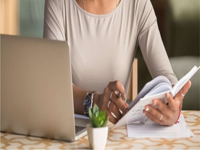

  2. ID: 2. financials.pdf_p1_img_2_visual, Type: image, Source: /content/2. financials.pdf, Page: 1, Similarity: 10000.0000
     Content (Image Placeholder): Image from 2. financials.pdf, page 1, index 2
     Image Path: extractedpdfimages/2. financials/page_1_img_2.jpeg


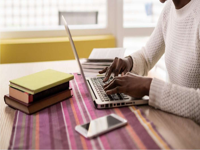

  3. ID: 2. financials.pdf_p17_img_2_visual, Type: image, Source: /content/2. financials.pdf, Page: 17, Similarity: 10000.0000
     Content (Image Placeholder): Image from 2. financials.pdf, page 17, index 2
     Image Path: extractedpdfimages/2. financials/page_17_img_2.jpeg


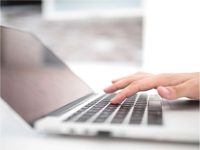

  4. ID: 2. financials.pdf_p14_img_3_visual, Type: image, Source: /content/2. financials.pdf, Page: 14, Similarity: 10000.0000
     Content (Image Placeholder): Image from 2. financials.pdf, page 14, index 3
     Image Path: extractedpdfimages/2. financials/page_14_img_3.jpeg


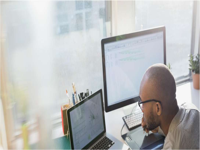

  5. ID: 2. financials.pdf_p20_img_2_visual, Type: image, Source: /content/2. financials.pdf, Page: 20, Similarity: 10000.0000
     Content (Image Placeholder): Image from 2. financials.pdf, page 20, index 2
     Image Path: extractedpdfimages/2. financials/page_20_img_2.jpeg


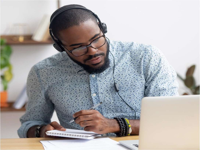

In [ ]:
print("\n--- Testing with an Image Query ---")

# Replace with the actual path to an image extracted earlier
# Example: Use the image from page 6 of the PWC doc if it looks like a table/chart
image_query_path = "/content/extractedpdfimages/2. financials/page_2_img_3.jpeg" # <--- CHANGE THIS PATH

if os.path.exists(image_query_path):
    try:
        query_image = Image.open(image_query_path)
        print(f"Using image '{image_query_path}' as query.")

        results_img = retrieve_relevant_chunks(query_image, n_results=5)

        if results_img:
            print(f"\nResults for image query: '{image_query_path}'")
            for i, res in enumerate(results_img):
                print(f"  {i+1}. ID: {res['id']}, Type: {res['metadata'].get('type', 'N/A')}, Source: {res['metadata'].get('source')}, Page: {res['metadata'].get('page')}, Similarity: {res['similarity']:.4f}")
                if res['metadata'].get('type') == 'image':
                    print(f"     Content (Image Placeholder): {res['content']}")
                    print(f"     Image Path: {res['metadata'].get('image_path')}")
                    # Display the retrieved image if it's an image chunk
                    display(Image.open(res['metadata'].get('image_path')).resize((200,150))) # Resize for display
                else:
                    print(f"     Content Snippet: {res['content'][:150]}...")

    except Exception as e:
        print(f"Error processing image query with path {image_query_path}: {e}")
else:
    print(f"Image query path not found: {image_query_path}. Please check the path.")

# Phase 6: Language Model Integration and Generation

In [ ]:
!pip install transformers accelerate bitsandbytes torch -q
!pip install --upgrade huggingface-hub

In [ ]:
!pip install transformers accelerate bitsandbytes torch sentence-transformers -q
# We also need sentence-transformers for embedding if not already installed/verified

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from google.colab import userdata # For HF token if needed, though usually not for this model

# --- Mistral Model Configuration ---
model_name = "mistralai/Mistral-7B-Instruct-v0.1"

print(f"\n--- Loading LLM: {model_name} with 4-bit quantization ---")

# Configure quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Get HF token if available (optional for this model but good practice)
hf_token = userdata.get('HF_TOKEN')

# Load the model
try:
    llm_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=quantization_config,
        device_map="auto",
        token=hf_token # Pass token if available/needed
    )

    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        token=hf_token
        )

    # Set padding token for Mistral if not set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        # Update the model config's pad token id as well
        llm_model.config.pad_token_id = tokenizer.pad_token_id

    print("Mistral LLM and Tokenizer loaded successfully.")

except Exception as e:
    print(f"Error loading Mistral model or tokenizer: {e}")
    llm_model = None
    tokenizer = None


--- Loading LLM: mistralai/Mistral-7B-Instruct-v0.1 with 4-bit quantization ---


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Mistral LLM and Tokenizer loaded successfully.


In [ ]:
import os # Make sure os is imported

def format_context_for_llm(results):
    """
    Formats the retrieved chunks into a readable string for the LLM prompt.

    Args:
        results (list): The list of dictionaries returned by retrieve_relevant_chunks.
                        Expected keys per dict: 'metadata', 'content', 'similarity'.
                        Metadata expected keys: 'source', 'page', 'type'.

    Returns:
        str: A formatted string containing the context.
    """
    context_str = "--- Retrieved Context ---\n"
    if not results:
        return context_str + "No relevant context found.\n--- End Context ---"

    for i, res in enumerate(results):
        metadata = res.get('metadata', {})
        content = res.get('content', '')
        # Use os.path.basename to get just the filename from the source path
        source_file = os.path.basename(metadata.get('source', 'N/A'))
        page = metadata.get('page', 'N/A')
        chunk_type = metadata.get('type', 'N/A')
        similarity = res.get('similarity', 'N/A') # Similarity score added in retrieval

        # Format the similarity score nicely, handle potential non-numeric case
        similarity_str = f"{similarity:.4f}" if isinstance(similarity, (int, float)) else str(similarity)

        context_str += f"\nChunk {i+1} (Source: {source_file}, Page: {page}, Type: {chunk_type}, Similarity: {similarity_str}):\n"

        # Add the actual content
        context_str += f"{content}\n"

        # Add a separator
        context_str += "---\n"

    context_str += "--- End Context ---"
    return context_str

In [ ]:
# Keep format_context_for_llm function

# --- Basic Prompt for Mistral Instruct ---
def create_mistral_basic_prompt(query, context):
    if not isinstance(query, str):
        query = "Describe the visual content based on the provided text context extracted from the image."

    # Mistral Instruct uses <s>[INST] and [/INST] tags
    prompt = f"""<s>[INST] You are a helpful AI assistant. Answer the following query based *only* on the provided context. If the context does not contain the answer, state that the information is not available in the provided documents. Do not add information that is not present in the context.

    Query: {query}

    Context:
    {context}

    Answer: [/INST]"""
    return prompt

# --- Chain-of-Thought (CoT) Prompt for Mistral Instruct ---
def create_mistral_cot_prompt(query, context):
    if not isinstance(query, str):
        query = "Analyze the visual content based on the provided text context extracted from the image, thinking step-by-step."

    prompt = f"""<s>[INST] You are a helpful AI assistant. Answer the following query based *only* on the provided context. Follow these steps:
    1. Carefully read the query and the provided context.
    2. Identify the key pieces of information within the context that are relevant to the query.
    3. Synthesize these pieces of information to formulate a step-by-step reasoning process.
    4. Based on the reasoning, provide a final answer to the query.
    5. If the context does not contain the information needed to answer the query, explicitly state that.
    Do not add external information.

    Query: {query}

    Context:
    {context}

    Reasoning Steps and Final Answer: [/INST]
    Reasoning:
    1. """ # Let the model start the reasoning steps
    return prompt

In [ ]:
def generate_local_llm_answer(prompt, model, tokenizer, max_new_tokens=250):
    """
    Generates an answer from the local LLM based on the provided prompt.
    """
    if not model or not tokenizer:
        return "[Local LLM not loaded]"

    print("\n--- Generating Local LLM Response ---")
    # Use a reasonable max_length for the input context + prompt
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=1024).to("cuda" if torch.cuda.is_available() else "cpu")

    # Generate output
    try:
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                temperature=0.7, # Can adjust temperature
                do_sample=True,
                top_p=0.9,
                pad_token_id=tokenizer.pad_token_id # Important!
            )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract only the response part (after the final [/INST])
        response_part = generated_text.split("[/INST]")[-1].strip()

        print("Local LLM Response Generated.")
        return response_part

    except Exception as e:
        print(f"Error during Local LLM generation: {e}")
        return "[Local LLM generation failed]"

In [ ]:
def get_rag_response_mistral_local(query, prompt_type='basic', n_results=5):
    """
    Performs the full RAG pipeline using the local Mistral model.
    """
    print(f"\n=== Starting RAG Pipeline (Local Mistral) for Query (Type: {prompt_type}) ===")

    # 1. Retrieve relevant chunks (Ensure retrieve_relevant_chunks is defined)
    results = retrieve_relevant_chunks(query, n_results=n_results)
    if results is None:
         return {"error": "Retrieval failed."}
    if not results:
        print("No relevant chunks found during retrieval.")
        formatted_context = format_context_for_llm(results) # Will indicate no context found
    else:
         formatted_context = format_context_for_llm(results)

    # 3. Create Mistral prompt
    if prompt_type == 'basic':
        final_prompt = create_mistral_basic_prompt(query, formatted_context)
    elif prompt_type == 'cot':
        final_prompt = create_mistral_cot_prompt(query, formatted_context)
    else:
        print(f"Warning: Unknown prompt type '{prompt_type}'. Using basic.")
        final_prompt = create_mistral_basic_prompt(query, formatted_context)

    # 4. Generate answer using local LLM
    llm_answer = generate_local_llm_answer(final_prompt, llm_model, tokenizer) # Pass local model/tokenizer

    print("=== RAG Pipeline Complete ===")

    return {
        "query": query if isinstance(query, str) else f"[Image Query: {getattr(query, 'filename', 'In-memory Image')}]",
        "retrieved_context_formatted": formatted_context,
        "prompt_used": final_prompt,
        "llm_answer": llm_answer,
        "retrieved_chunks_details": results
    }

In [ ]:
print("\n\n======= TESTING THE FULL RAG PIPELINE (Local Mistral) =======")

if llm_model and tokenizer: # Check if model loaded successfully
    # --- Test Case 1: Basic Prompt ---
    query1 = "What is the purpose of a cash flow statement?"
    response1_basic = get_rag_response_mistral_local(query1, prompt_type='basic')
    print("\n--- Query 1 (Basic) ---")
    print(f"Query: {response1_basic['query']}")
    # print(f"\nContext:\n{response1_basic['retrieved_context_formatted']}")
    # print(f"\nPrompt Used:\n{response1_basic['prompt_used']}")
    print(f"\nAnswer:\n{response1_basic['llm_answer']}")
    print("-" * 30)

    # --- Test Case 2: CoT Prompt ---
    query2 = "Explain the difference between current and non-current assets, giving examples."
    response2_cot = get_rag_response_mistral_local(query2, prompt_type='cot')
    print("\n--- Query 2 (CoT) ---")
    print(f"Query: {response2_cot['query']}")
    print(f"\nAnswer:\n{response2_cot['llm_answer']}")
    print("-" * 30)

    # --- Test Case 3: Query about FAST University ---
    query3 = "What research areas are mentioned for the Islamabad campus faculty?"
    response3_basic = get_rag_response_mistral_local(query3, prompt_type='basic')
    print("\n--- Query 3 (Basic) ---")
    print(f"Query: {response3_basic['query']}")
    print(f"\nAnswer:\n{response3_basic['llm_answer']}")
    print("-" * 30)

    # --- Test Case 4: Image Query (Use the path from Phase 5) ---
    image_query_path_test = "/content/extractedpdfimages/2. financials/page_11_img_4.jpeg" # <--- USE SAME PATH AS BEFORE
    if os.path.exists(image_query_path_test):
        try:
            img_query = Image.open(image_query_path_test)
            img_query.filename = image_query_path_test # Add filename for logging
            response4_img = get_rag_response_mistral_local(img_query, prompt_type='basic')
            print("\n--- Query 4 (Image) ---")
            print(f"Query: {response4_img['query']}")
            print(f"\nAnswer:\n{response4_img['llm_answer']}")
            print("-" * 30)
        except Exception as e:
            print(f"Error processing image query: {e}")
    else:
        print(f"Image path not found for test: {image_query_path_test}")

else:
    print("\nSkipping pipeline tests because Mistral model failed to load.")



======= TESTING THE FULL RAG PIPELINE (Local Mistral) =======

=== Starting RAG Pipeline (Local Mistral) for Query (Type: basic) ===
Embedding text query: 'What is the purpose of a cash flow statement?...'

--- Generating Local LLM Response ---
Local LLM Response Generated.
=== RAG Pipeline Complete ===

--- Query 1 (Basic) ---
Query: What is the purpose of a cash flow statement?

Answer:
The purpose of a cash flow statement is to provide information about a company's cash position and its ability to generate cash. It does this by showing the inflows and outflows of cash, including injections of external finance, and the sources of cash. The statement is audited to ensure accuracy for tax, financing, or investing purposes. The cash flow statement is one of the three financial statements used to assess a company's financial health, along with the balance sheet and income statement.
------------------------------

=== Starting RAG Pipeline (Local Mistral) for Query (Type: cot) ===
Embe

Evaluation

In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Install libraries if not already present
!pip install matplotlib seaborn scikit-learn rouge-score nltk -q

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import time
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import random # To sample data for visualization if needed
import pandas as pd # Optional: for easier data handling/display

# Ensure NLTK data is available for tokenization (needed for BLEU)
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

print("Evaluation libraries loaded.")


# Check if core components seem available (replace with your actual variable names if different)
try:
    _ = collection.count()
    _ = embedding_model
    _ = llm_model
    _ = tokenizer
    print("Core RAG components appear to be loaded.")
except NameError as e:
    print(f"Error: A required component ({e}) is not defined. Please run previous pipeline cells.")
except Exception as e:
    print(f"Error accessing RAG component: {e}")

Evaluation libraries loaded.
Core RAG components appear to be loaded.


In [ ]:
# --- DEFINE YOUR EVALUATION DATA HERE ---
# Add more diverse queries covering different documents and types (text/image)
evaluation_set = [
    {
        "query_id": "PWC_Q1",
        "query": "What are the main components of a balance sheet?",
        "query_type": "text",
        # Identify relevant chunk IDs from your Chroma DB (e.g., 'chunk_5', 'chunk_6')
        "expected_ids": ["2. financials.pdf_p4_directtext_chunk_2","2. financials.pdf_p6_directtext_chunk_4","2. financials.pdf_p31_directtext_chunk_4"], # <-- !!! UPDATE WITH ACTUAL CHUNK IDs !!!
        "reference_answer": "A balance sheet has three main categories: Assets, Liabilities, and Equity. Assets include current assets (like cash, accounts receivable, inventory) and non-current assets (like property, plant & equipment). Liabilities include current liabilities (like accounts payable) and non-current liabilities (like long-term loans). Equity includes components like common shares and retained earnings." # <-- !!! WRITE A GOOD REFERENCE ANSWER FROM DOCS !!!
    },
    {
        "query_id": "PWC_Q2",
        "query": "Explain the difference between current and non-current assets.",
        "query_type": "text",
        "expected_ids": ["2. financials.pdf_p10_img_3_ocr_chunk_1", "2. financials.pdf_p12_img_2_ocr_chunk_1","2. financials.pdf_p29_img_3_ocr_chunk_1"], # <-- !!! UPDATE !!!
        "reference_answer": "Current assets are expected to be converted into cash in less than one year (e.g., accounts receivable, inventory). Non-current assets are expected to be held for longer than one year (e.g., property, plant, and equipment)." # <-- !!! WRITE REFERENCE !!!
    },
    {
        "query_id": "FAST_Report_Q1",
        "query": "Which campuses offer a PhD in Computer Science?",
        "query_type": "text",
        "expected_ids": ["1. Annual Report 2023-24.pdf_p7_directtext_chunk_9","1. Annual Report 2023-24.pdf_p44_directtext_chunk_10","1. Annual Report 2023-24.pdf_p53_directtext_chunk_13"], # <-- !!! UPDATE !!! (These IDs are placeholders)
        "reference_answer": "The PhD in Computer Science is offered at the CFD, ISB, KHI, LHR, and PWR campuses according to the table on page 12." # <-- !!! WRITE REFERENCE !!!
    },
    {
        "query_id": "FYP_Handbook_Q1",
        "query": "What is the minimum passing mark for an FYP student?",
        "query_type": "text",
        "expected_ids": ["3. FYP-Handbook-2023.pdf_p40_directtext_chunk_1", "3. FYP-Handbook-2023.pdf_p44_directtext_chunk_1"], # <-- !!! UPDATE !!!
        "reference_answer": "The minimum passing mark for an FYP student is 50% according to the handbook (page 11)." # <-- !!! WRITE REFERENCE !!!
    },
    {
        "query_id": "Image_Q1",
        "query": "/content/extractedpdfimages/2. financials/page_11_img_3.jpeg", # <-- !!! UPDATE PATH !!!
        "query_type": "image",
        "expected_ids": ["1. Annual Report 2023-24.pdf_p19_directtext_chunk_8","2. financials.pdf_p13_img_2_ocr_chunk_1","2. financials.pdf_p29_img_3_ocr_chunk_1"], # <-- !!! UPDATE (include text, ocr, and image chunks) !!!
        "reference_answer": "This page displays a simplified balance sheet containing current assets (Cash, Accounts receivable, Inventory, Prepaid expenses), non-current assets (Property plant & equipment, Intangible assets), current liabilities (Accounts payable, Accrued expenses), non-current liabilities (Bank loan), and shareholder equity (Common shares, Retained Earnings). It also defines current and non-current assets and liabilities." # <-- !!! WRITE REFERENCE !!!
    }
]

# --- Helper function to load image query if needed ---
def load_query(query_data):
    if query_data["query_type"] == "image":
        try:
            img = Image.open(query_data["query"])
            img.filename = query_data["query"] # Store path for reference
            return img
        except FileNotFoundError:
            print(f"Warning: Image file not found for query {query_data['query_id']}: {query_data['query']}")
            return None
        except Exception as e:
            print(f"Warning: Error loading image for query {query_data['query_id']}: {e}")
            return None
    else:
        return query_data["query"] # Return the text query string

print(f"Defined {len(evaluation_set)} evaluation queries.")

Defined 5 evaluation queries.


In [ ]:
# --- INSPECTION CODE --- (Run this in a separate cell)

query_to_inspect = ["/content/extractedpdfimages/2. financials/page_11_img_3.jpeg"] # Or use the actual query
# query_to_inspect = "Assets, Liabilities, and Equity" # Or use keywords from reference answer

print(f"\n--- Inspecting chunks for query: '{query_to_inspect}' ---")

for i in query_to_inspect:
    inspection_results = retrieve_relevant_chunks(i, n_results=3)
    if inspection_results:
      print("Found potential chunks:")
      for i, res in enumerate(inspection_results):

        print(f"{res['id']}")

else:
    print("No results found for inspection query.")
# Use your existing retrieval function, ask for more results
inspection_results = retrieve_relevant_chunks(query_to_inspect, n_results=15)



# --- END INSPECTION CODE ---


--- Inspecting chunks for query: '['/content/extractedpdfimages/2. financials/page_11_img_3.jpeg']' ---
Embedding text query: '/content/extractedpdfimages/2. financials/page_11_img_3.jpeg...'
Found potential chunks:
1. Annual Report 2023-24.pdf_p19_directtext_chunk_8
2. financials.pdf_p13_img_2_ocr_chunk_1
2. financials.pdf_p29_img_3_ocr_chunk_1
No results found for inspection query.
Error: Query must be string or PIL Image



--- Visualizing Embedding Space (t-SNE) ---
Subsampling 1805 points down to 1500 for t-SNE visualization...
Running t-SNE on 1500 embeddings...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


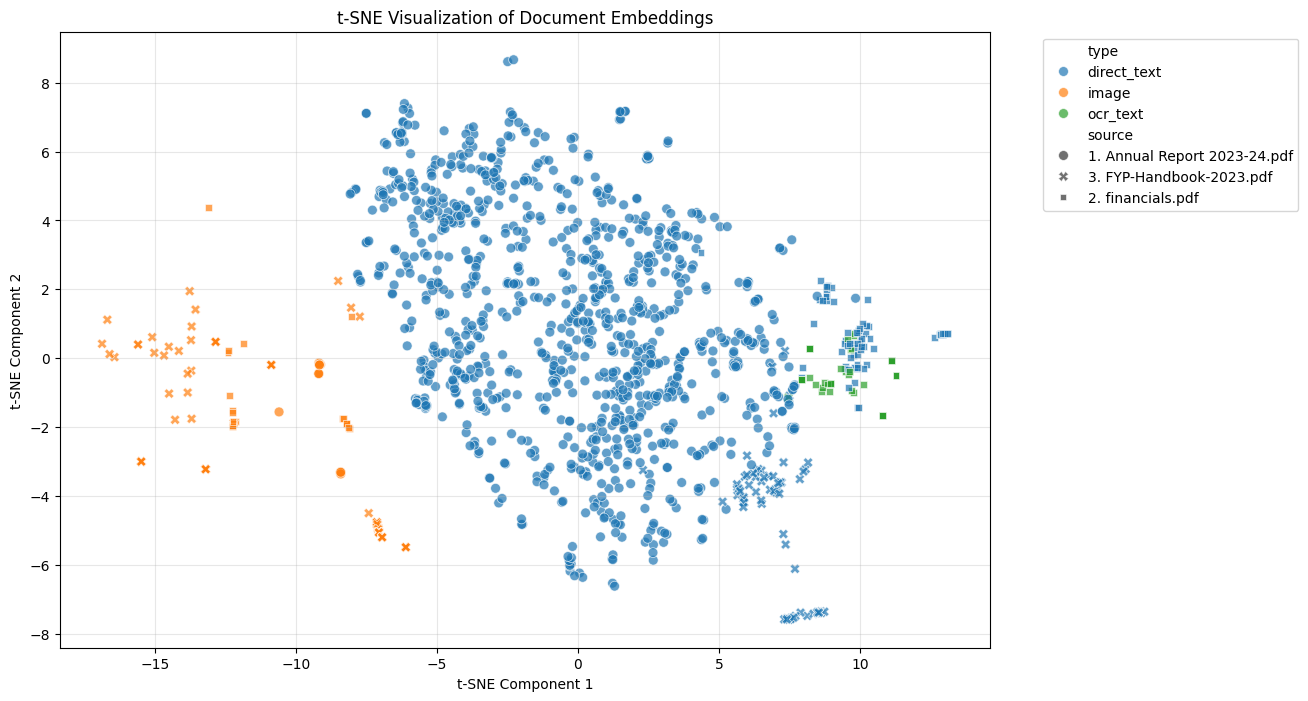

In [ ]:
print("\n--- Visualizing Embedding Space (t-SNE) ---")

# Get embeddings and metadata from ChromaDB
try:
    # Reduce limit if dataset is huge and causing memory issues
    limit_for_viz = 2000
    data = collection.get(
        include=['embeddings', 'metadatas'],
        limit=limit_for_viz # Limit if needed, otherwise get all
    )
    embeddings = np.array(data['embeddings'])
    metadatas = data['metadatas']
    ids = data['ids'] # Get IDs as well

    # Optional: Subsample if too many points for t-SNE
    num_points = embeddings.shape[0]
    if num_points > 1500: # Subsample if more than 1500 points
        print(f"Subsampling {num_points} points down to 1500 for t-SNE visualization...")
        indices = random.sample(range(num_points), 1500)
        embeddings = embeddings[indices]
        metadatas = [metadatas[i] for i in indices]
        ids = [ids[i] for i in indices] # Keep track of sampled IDs if needed
        num_points = 1500


    if num_points > 1: # Need at least 2 points for t-SNE
        print(f"Running t-SNE on {num_points} embeddings...")
        tsne = TSNE(n_components=2, perplexity=min(30, num_points-1), n_iter=300, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings)

        # Create a DataFrame for easier plotting with seaborn
        df_viz = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
        df_viz['type'] = [m.get('type', 'unknown') for m in metadatas]
        df_viz['source'] = [os.path.basename(m.get('source', 'unknown')) for m in metadatas]

        # Plotting
        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=df_viz, x='x', y='y', hue='type', style='source', s=50, alpha=0.7)
        plt.title('t-SNE Visualization of Document Embeddings')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("Not enough data points (<2) for t-SNE visualization.")

except Exception as e:
    print(f"Error during t-SNE visualization: {e}")

In [ ]:
print("\n--- Evaluating Retrieval Metrics ---")
K = 5 # Number of results to consider for metrics
retrieval_results = {}
total_queries = len(evaluation_set)
hits = 0
similarity_scores_sum = 0
queries_with_results = 0

for item in evaluation_set:
    query_id = item["query_id"]
    query = load_query(item)
    expected = item["expected_ids"]
    print(f"  Processing Query: {query_id}")

    if query is None and item["query_type"] == "image":
        print("    Skipping retrieval due to missing image.")
        retrieval_results[query_id] = {'hit': False, 'avg_similarity': 0, 'retrieved_ids': [], 'error': 'Image not found'}
        continue

    # Perform retrieval
    retrieved = retrieve_relevant_chunks(query, n_results=K) # Assumes this function exists
    retrieval_results[query_id] = {'hit': False, 'avg_similarity': 0, 'retrieved_ids': []}

    if retrieved:
        queries_with_results += 1
        retrieved_ids = [res['id'] for res in retrieved]
        retrieval_results[query_id]['retrieved_ids'] = retrieved_ids

        # Check for Hit
        hit_found = any(expected_id in retrieved_ids for expected_id in expected)
        retrieval_results[query_id]['hit'] = hit_found
        if hit_found:
            hits += 1
            print("    Hit!")
        else:
            print("    Miss.")
        print(f"    Expected: {expected}, Retrieved: {retrieved_ids}")


        # Calculate Average Similarity
        avg_sim = np.mean([res['similarity'] for res in retrieved]) if retrieved else 0
        retrieval_results[query_id]['avg_similarity'] = avg_sim
        similarity_scores_sum += avg_sim
    else:
         print("    No results retrieved.")
         retrieval_results[query_id]['error'] = 'No results retrieved'


# Calculate Overall Metrics
hit_rate = (hits / total_queries) * 100 if total_queries > 0 else 0
mean_avg_similarity = (similarity_scores_sum / queries_with_results) if queries_with_results > 0 else 0

print("\n--- Retrieval Metrics Summary ---")
print(f"Hit Rate@{K}: {hit_rate:.2f}% ({hits}/{total_queries} queries had a relevant item in top {K})")
print(f"Mean Average Similarity@{K}: {mean_avg_similarity:.4f} (Average similarity of top {K} results, averaged over queries that returned results)")

# You can inspect individual query results in the 'retrieval_results' dictionary
# print(retrieval_results)


--- Evaluating Retrieval Metrics ---
  Processing Query: PWC_Q1
Embedding text query: 'What are the main components of a balance sheet?...'
    Hit!
    Expected: ['2. financials.pdf_p4_directtext_chunk_2', '2. financials.pdf_p6_directtext_chunk_4', '2. financials.pdf_p31_directtext_chunk_4'], Retrieved: ['2. financials.pdf_p4_directtext_chunk_2', '2. financials.pdf_p6_directtext_chunk_4', '2. financials.pdf_p31_directtext_chunk_4', '2. financials.pdf_p10_directtext_chunk_1', '2. financials.pdf_p4_directtext_chunk_3']
  Processing Query: PWC_Q2
Embedding text query: 'Explain the difference between current and non-current assets....'
    Hit!
    Expected: ['2. financials.pdf_p10_img_3_ocr_chunk_1', '2. financials.pdf_p12_img_2_ocr_chunk_1', '2. financials.pdf_p29_img_3_ocr_chunk_1'], Retrieved: ['2. financials.pdf_p7_img_3_ocr_chunk_1', '2. financials.pdf_p10_img_3_ocr_chunk_1', '2. financials.pdf_p12_img_2_ocr_chunk_1', '2. financials.pdf_p13_img_2_ocr_chunk_1', '2. financials.pdf_p2

In [ ]:
print("\n--- Evaluating Generation Metrics ---")

# Initialize scorers
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
chencherry = SmoothingFunction() # For BLEU smoothing

generation_eval_results = []
response_times = []

for item in evaluation_set:
    query_id = item["query_id"]
    query = load_query(item)
    reference = item["reference_answer"]
    print(f"  Processing Query for Generation: {query_id}")

    if query is None and item["query_type"] == "image":
        print("    Skipping generation due to missing image.")
        continue

    # Run the full RAG pipeline
    start_time = time.time()
    # --- Use your final RAG function name ---
    response_data = get_rag_response_mistral_local(query, prompt_type='basic', n_results=K) # Use 'cot' if testing that
    # ------------------------------------
    end_time = time.time()
    response_time = end_time - start_time
    response_times.append(response_time)

    generated_answer = response_data.get('llm_answer', '[Generation Failed]')
    retrieved_context = response_data.get('retrieved_context_formatted', '[Context Not Available]')

    # --- Manual Evaluation Section (Requires User Input) ---
    print("\n  --- Manual Evaluation Needed ---")
    print(f"  Query ID: {query_id}")
    print(f"  Query: {item['query']}") # Display original query text/path
    print(f"  Reference Answer:\n    {reference}")
    print("-" * 10)
    # Display context to help judge faithfulness
    print(f"  Retrieved Context (for faithfulness check):\n{retrieved_context}")
    print("-" * 10)
    print(f"  Generated Answer:\n    {generated_answer}")
    # Provide instructions for manual scoring (e.g., Relevance 1-5, Faithfulness 1-5)
    print("  >>> Please manually evaluate Relevance (1-5) and Faithfulness (1-5) based on the query, context, and answer.")
    # In a real scenario, you'd collect these scores. We'll skip collection in code.
    manual_relevance = "N/A (Manual Score)"
    manual_faithfulness = "N/A (Manual Score)"
    print("  --- End Manual Evaluation ---\n")


    # --- Automatic Metrics (BLEU/ROUGE) ---
    bleu_score = 0
    rouge_scores = {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0} # Default scores

    if generated_answer and reference and not generated_answer.startswith("["): # Avoid scoring failures
        try:
            # Preprocess for BLEU
            reference_tokens = [nltk.word_tokenize(reference.lower())]
            generated_tokens = nltk.word_tokenize(generated_answer.lower())
            # Calculate BLEU (using smoothing for short sentences)
            bleu_score = sentence_bleu(reference_tokens, generated_tokens, smoothing_function=chencherry.method1)

            # Calculate ROUGE
            scores = rouge.score(reference, generated_answer)
            rouge_scores = {
                'rouge1': scores['rouge1'].fmeasure,
                'rouge2': scores['rouge2'].fmeasure,
                'rougeL': scores['rougeL'].fmeasure,
            }
        except Exception as e:
            print(f"    Warning: Error calculating BLEU/ROUGE for query {query_id}: {e}")

    generation_eval_results.append({
        "query_id": query_id,
        "response_time": response_time,
        "bleu": bleu_score,
        "rouge1": rouge_scores['rouge1'],
        "rouge2": rouge_scores['rouge2'],
        "rougeL": rouge_scores['rougeL'],
        "manual_relevance": manual_relevance,
        "manual_faithfulness": manual_faithfulness,
        "generated_answer": generated_answer # Keep for reference
    })


# Calculate Average Metrics
avg_response_time = np.mean(response_times) if response_times else 0
avg_bleu = np.mean([r['bleu'] for r in generation_eval_results]) if generation_eval_results else 0
avg_rouge1 = np.mean([r['rouge1'] for r in generation_eval_results]) if generation_eval_results else 0
avg_rouge2 = np.mean([r['rouge2'] for r in generation_eval_results]) if generation_eval_results else 0
avg_rougeL = np.mean([r['rougeL'] for r in generation_eval_results]) if generation_eval_results else 0

print("\n--- Generation Metrics Summary ---")
print(f"Average Query Response Time: {avg_response_time:.2f} seconds")
print(f"Average BLEU Score: {avg_bleu:.4f}")
print(f"Average ROUGE-1 F1: {avg_rouge1:.4f}")
print(f"Average ROUGE-2 F1: {avg_rouge2:.4f}")
print(f"Average ROUGE-L F1: {avg_rougeL:.4f}")
print("Manual Scores (Relevance/Faithfulness) require user inspection (see output above).")

# Display results in a table (optional)
if generation_eval_results:
    df_gen_eval = pd.DataFrame(generation_eval_results)
    print("\nGeneration Evaluation Details:")
    # Select and format columns for display
    display(df_gen_eval[['query_id', 'response_time', 'bleu', 'rougeL', 'manual_relevance', 'manual_faithfulness']])


--- Evaluating Generation Metrics ---
  Processing Query for Generation: PWC_Q1

=== Starting RAG Pipeline (Local Mistral) for Query (Type: basic) ===
Embedding text query: 'What are the main components of a balance sheet?...'

--- Generating Local LLM Response ---
Local LLM Response Generated.
=== RAG Pipeline Complete ===

  --- Manual Evaluation Needed ---
  Query ID: PWC_Q1
  Query: What are the main components of a balance sheet?
  Reference Answer:
    A balance sheet has three main categories: Assets, Liabilities, and Equity. Assets include current assets (like cash, accounts receivable, inventory) and non-current assets (like property, plant & equipment). Liabilities include current liabilities (like accounts payable) and non-current liabilities (like long-term loans). Equity includes components like common shares and retained earnings.
----------
  Retrieved Context (for faithfulness check):
--- Retrieved Context ---

Chunk 1 (Source: 2. financials.pdf, Page: 4, Type: direct_

,query_id,response_time,bleu,rougeL,manual_relevance,manual_faithfulness
0,PWC_Q1,9.980225,0.149856,0.258621,N/A (Manual Score),N/A (Manual Score)
1,PWC_Q2,15.177890,0.135723,0.396947,N/A (Manual Score),N/A (Manual Score)
2,FAST_Report_Q1,17.051714,0.034735,0.134615,N/A (Manual Score),N/A (Manual Score)
3,FYP_Handbook_Q1,5.131678,0.420038,0.645161,N/A (Manual Score),N/A (Manual Score)
4,Image_Q1,13.763325,0.002762,0.049689,N/A (Manual Score),N/A (Manual Score)


In [ ]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹
changed 22 packages in 1s
⠹
⠹3 packages are looking for funding
⠹  run `npm fund` for details
⠹

In [ ]:
!curl https://loca.lt/mytunnelpassword


34.142.172.10

In [ ]:
# Make sure app.py is in the current directory (/content/) or specify the path
!streamlit run app.py &>/dev/null&

# Expose port 8501 using localtunnel
!npx localtunnel --port 8501

⠙⠹⠸⠼⠴your url is: https://six-beans-juggle.loca.lt
